## Chicago Chain Runs
#### 50 Wards Out Of Precincts

This notebook performs the following chain run:
- Out of precincts:
    - 50 wards of equal population
        - Population deviation tolerance of 5%

In [1]:
from collections import defaultdict
from datetime import datetime
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm
import pathlib
import glob
import numpy as np
import statistics
from mapclassify import greedy

from gerrychain.random import random
import gerrychain as gc
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import recom
from gerrychain import accept
from gerrychain.tree import bipartition_tree, predecessors, random_spanning_tree
import json

# pd.set_option('display.max_columns', None)

In [2]:
ca_df = geopandas.read_file("../shapefiles/chicago_comareas_economic.shp").set_index("area_num_1")
df = geopandas.read_file("../shapefiles/chicago_precincts_economic.shp").set_index("JOINID")
df = df.join((geopandas.sjoin(df, ca_df, how="inner",lsuffix="left",rsuffix="right")[["community"]]),how="left").drop_duplicates(subset=["full_text"])

In [3]:
# Create the graph
# df = geopandas.read_file("../shapefiles/chicago_precincts_economic.shp").set_index("JOINID")
alder_precincts = pd.read_csv("../shapefiles/alder-precincts.tsv",sep="\t").set_index("Precinct")
df = df.join(alder_precincts[["Alderperson"]])
precincts = gc.Graph.from_geodataframe(df, reproject=False)
precincts.add_data(df)

In [4]:
alder_dict = alder_precincts.set_index("WARD").to_dict()['Alderperson']
# max is a cheap way to group by to find count, because precincts are one-indexed and increase by one presumably with no gaps...
total_precincts_dict = df[["precinct","ward"]].groupby("ward").max().to_dict()['precinct']
precincts_by_alder = {alder_dict[k]:v for (k,v) in total_precincts_dict.items()}
# print(list(alder_dict.values()) + ["Alderperson"])

In [5]:
partition = gc.Partition(precincts, assignment=df.ward)

In [6]:
votes_2019 = geopandas.read_file("../shapefiles/municipal_general_2019.geojson")
votes_2019["JOINID"] = votes_2019[["WARD","PRECINCT"]].apply(lambda x: f"C{x[0]:02}{x[1]:03}",axis=1)
votes_2019 = votes_2019.set_index("JOINID")
dontcares = ["PRECINCT","JERRY JOYCE","PAUL VALLAS","WILLIE L. WILSON","TONI PRECKWINKLE","WILLIAM M. DALEY","GARRY MCCARTHY","GERY CHICO","SUSANA A. MENDOZA","AMARA ENYIA","LA SHAWN K. FORD","NEAL SALES-GRIFFIN","LORI LIGHTFOOT","ROBERT 'BOB' FIORETTI","JOHN KENNETH KOZLAR","REGISTERED VOTERS","BALLOTS CAST","geometry"]
votes_2019 = votes_2019.drop(columns=dontcares)
votes_2019["Alderperson"] = votes_2019["WARD"].map(alder_dict)
votes_2019 = votes_2019.drop(columns=["WARD"])
pd.set_option('display.max_rows', 100)
votes_2019["winner_votes"] = votes_2019.apply(lambda x: x[x["Alderperson"]],axis=1)
votes_2019 = votes_2019.drop(columns=list(alder_dict.values()) + ["Alderperson"])
votes_2019["loser_votes"] = votes_2019.apply(lambda x: np.nanmax(x[:-1]),axis=1)
votes_2019["margin_2019_general"] = votes_2019["winner_votes"] - votes_2019["loser_votes"]
df = df.join(votes_2019[["margin_2019_general"]])

## Generating a seed plan with < 5% deviation

In [7]:
def recursive_tree_part(graph, parts, pop_col, epsilon, node_repeats=18):
    """Uses :func:`~gerrychain.tree_methods.bipartition_tree` recursively to partition a tree into
    ``len(parts)`` parts of population ``pop_target`` (within ``epsilon``). Can be used to
    generate initial seed plans or to implement ReCom-like "merge walk" proposals.
    :param graph: The graph
    :param parts: Iterable of part labels (like ``[0,1,2]`` or ``range(4)``
    :param pop_target: Target population for each part of the partition
    :param pop_col: Node attribute key holding population data
    :param epsilon: How far (as a percentage of ``pop_target``) from ``pop_target`` the parts
        of the partition can be
    :param node_repeats: Parameter for :func:`~gerrychain.tree_methods.bipartition_tree` to use.
    :return: New assignments for the nodes of ``graph``.
    :rtype: dict
    """
    flips = {}
    remaining_nodes = set(graph.nodes)
    
    total_pop = sum(graph.nodes[node][pop_col] for node in graph)
    remaining_pop = total_pop
    ideal_pop = total_pop / len(parts)
    pop_target = ideal_pop
    initial_epsilon = epsilon
    
    for i, part in enumerate(parts[:-1]):
        pop_target = remaining_pop / (len(parts) - i)
        nodes = bipartition_tree(
            graph.subgraph(remaining_nodes), pop_col, pop_target, epsilon, node_repeats
        )

        for node in nodes:
            flips[node] = part
        remaining_pop -= sum(graph.nodes[node][pop_col] for node in nodes)
        remaining_nodes -= nodes

    # All of the remaining nodes go in the last part
    for node in remaining_nodes:
        flips[node] = parts[-1]

    return flips

In [8]:
# Create an initial plan that does not violate population constraints
num_partitions = 50
pop_col = "TOTPOP"

# This modified recursive_tree_part manages to get below 5% deviation if
# you ask for 3%
assignment = recursive_tree_part(
    precincts,
    parts=range(num_partitions),
    pop_col=pop_col,
    epsilon=0.025,
)

In [9]:
# with open("./prec50/initial_assignment.json", "w") as f:
#     json.dump(assignment, f)

## Running the chain

In [10]:
# with open("./prec50/initial_assignment.json") as f:
#     assignment = json.load(f)

In [9]:
def alders_in_this_ward(partition):
    alders = defaultdict(list)
    for index, row in alder_precincts.iterrows():
        new_ward = partition.assignment[index]
        alders[new_ward].append(row[1])
    return alders

In [10]:
# Create an election object and updaters
# election = gc.Election("M15", ["Emanuel_M1", "Wilson_M15", "Fioretti_M", "Garcia_M15", "Walls_M15"])

updaters = {"population": gc.updaters.Tally("TOTPOP", alias="population"), "cut_edges": gc.updaters.cut_edges, "incumbents": alders_in_this_ward}

variables = [
    "TOTPOP", "HISP", "NH_WHITE", "NH_BLACK", "NH_ASIAN",
    "VAP", "HVAP", "WVAP", "BVAP", "ASIANVAP",'TOTHH', 'LESS_10K', '10K_15K', '15K_20K', '20K_25K',
       '25K_30K', '30K_35K', '35K_40K', '40K_45K', '45K_50K', '50K_60K',
       '60K_75K', '75K_100K', '100K_125K', '125K_150K', '150K_200K',
       '200K_MORE'
]
extra_variables = ['incumbency_advantage','proportions']
extra_metrics = ['cohesion', "two_ward_cohesion", "targeted_advantage_mean"]
attrs = {key: gc.updaters.Tally(key, alias=key) for key in variables}
updaters.update(attrs)

# Create an initial partition
initial = gc.Partition(
    precincts,
    assignment=assignment,
    updaters=updaters
)

In [11]:
"""
a map has (x,y) community cohesion if for every ward, either a single community area contributes >= x% of the population of that ward,
or that ward contributes >= y% of its population to an individual community area.
e.g. (60, 60) would mean that 60% of (some CA) is in that ward, or 60% of that ward is in (some CA)

first is a ward's "largest contributor", second is a ward's "largest contribution"

This approach might balkanize a specific community area - the challenge is that community areas have such widely varying populations, e.g. west town or logan, that there's no way to keep them cohesive within a given ward, and making sure that every ward contributes or is contributed to seems to get close.

NYI:
How might you quantify / minimize balkanization? contributions to individual community areas below X% cannot account for Y% of its total area? so like, you don't want a CA to have 15%, 15%, 15%, 15% - for (20,50) balkanization, this would be unacceptable because then 60% of the CA's population comes from minority contributions to other wards, likely causing lack of cohesive govt for that CA.

maybe a bit more simply: for all CAs, there must be one ward contributing at least X% of that CA's total population, so like at least 35% of a CA is represented by an individual alder.
"""
def all_proportions(initial):
    ca_populations = defaultdict(int)
    ward_populations = defaultdict(int)
    ca_proportions = defaultdict(lambda: defaultdict(int))
    ward_proportions = defaultdict(lambda: defaultdict(int))
    for node in initial.graph.nodes:
        this_precinct_ca = initial.graph.nodes[node]["community"]
        this_precinct_ward = initial.assignment[node]
        this_precinct_population = initial.graph.nodes[node]["TOTPOP"]
        ca_populations[this_precinct_ca] += this_precinct_population
        ward_populations[this_precinct_ward] += this_precinct_population
    for node in initial.graph.nodes:
        this_precinct_ca = initial.graph.nodes[node]["community"]
        this_precinct_ward = initial.assignment[node]
        this_precinct_population = initial.graph.nodes[node]["TOTPOP"]
        ca_proportions[this_precinct_ca][this_precinct_ward] += this_precinct_population / ca_populations[this_precinct_ca]
        ward_proportions[this_precinct_ward][this_precinct_ca] += this_precinct_population / ward_populations[this_precinct_ward]
    proportions = defaultdict(dict)
    for neighborhood, val in ca_proportions.items():
        for ward, proportion in val.items():
            if proportions[ward].get("contribution") == None or proportion > proportions[ward]["contribution"][1]:
                proportions[ward]["contribution"] = (neighborhood, proportion)
    for ward, val in ward_proportions.items():
        for neighborhood, proportion in val.items():
            if proportions[ward].get("contributor") == None or proportion > proportions[ward]["contributor"][1]:
                proportions[ward]["contributor"] = (neighborhood, proportion)
    return {'ca_populations': ca_populations, 'proportions': proportions,'ca_proportions': ca_proportions, 'ward_proportions': ward_proportions}

def proportions(partition):
    return partition['all_proportions']['proportions']

def ca_proportions(partition):
    return partition['all_proportions']['ca_proportions']

def ward_proportions(partition):
    return partition['all_proportions']['ward_proportions']

def ca_populations(partition):
    return partition['all_proportions']['ca_populations']

def cohesion(partition):
    """
    This is a "symmetric" cohesion metric - it finds the smallest proportion
    for which every ward either contributes at least that much OR takes that
    much of a contribution from a given CA.
    """
    lowest_high_val = 100
    for key, val in partition["proportions"].items():
        high = max(val['contribution'][1], val['contributor'][1])
        lowest_high_val = min(lowest_high_val,high)
    return lowest_high_val

def two_ward_cohesion(partition):
    """
    What's the smallest sum of the two largest wards representing a single CA?
    """
    return min([sum(sorted(partition['ca_proportions'][x].values())[-2:]) for x in partition['ca_populations'].keys()])

def ca_cohesion(partition):
    """
    the smallest largest-contribution to a given community area, 
    e.g. 20% would mean that there's one CA where the largest component of that CA
    in an individual ward is 20% of the CA's population
    (and every other ward in that CA contributes less than 20%)
    """
    return min([max(partition['ca_proportions'][x].values()) for x in partition['ca_populations'].keys()])


def cohesion_constraint(x,y, partition):
    """
    If you wanted to restrict drawn maps to be of a given cohesion,
    you could create a partial(cohesion_constraint,x,y) application
    and set it as a constraint.
    """
    retval = True
    for key, val in partition["proportions"].items():
        if val['contribution'][1] >= x or val['contributor'][1] >= y:
            continue
        else:
            # print(f"unsatisfied: {key}'s largest contribution is {val['contribution'][0]} at {val['contribution'][1]} (needs {x}) and " +
            #     f"{key}'s largest contributor is {val['contributor'][0]} at {val['contributor'][1]} (needs {y})")
            retval = False
    return retval

updaters["all_proportions"] = all_proportions
updaters["proportions"] = proportions
updaters["ca_proportions"] = ca_proportions
updaters["ward_proportions"] = ward_proportions
updaters["ca_populations"] = ca_populations
updaters["cohesion"] = cohesion
updaters["ca_cohesion"] = ca_cohesion
updaters["two_ward_cohesion"] = two_ward_cohesion

## Incumbent margin
* Each new district will have 0 or more incumbents drawn into it by home precinct.
* For each of those incumbents, some number of "above median" vote margin precincts will be drawn into that new ward.
* to compute this %, we need: # of above average precincts per incumbent, plus total # of above median precincts (to compute %)
* It might _also_ be useful to tweak whether this is above median, or above average, or top 75th percentile - generally, name recognition goes a long way and if an alder has been getting their name out there for the last 4 years, they might be better off than having a completely foreign precinct.


new columns:
name of incumbent
percentile of margin


In [12]:
temp_df = df[["ward","margin_2019_general"]].groupby("ward")["margin_2019_general"].apply(list).reset_index(name="new")
temp_df["margin_sorted"] = temp_df.apply(lambda x: sorted(x[1]),axis=1)
temp_df = temp_df.drop("new",axis=1)
temp_df["margin_percentile"] = temp_df.apply(lambda x: [y / len(x[1]) for y in range(len(x[1]))],axis=1)
temp_df["margin_percentile_map"] = temp_df.apply(lambda x: {x[1][y]:x[2][y] for y in range(len(x[1]))},axis=1)
temp_df = df[["full_text","ward","margin_2019_general"]].merge(temp_df,on="ward")
temp_df["incumbent_margin_2019_percentile"] = temp_df.apply(lambda x: x[5][x[2]] if not pd.isna(x[2]) else 0,axis=1)
df["incumbent_margin_2019_percentile"] = temp_df["incumbent_margin_2019_percentile"].tolist()

In [13]:
def incumbency_advantage_updater(initial, threshold=.5):
    """
    count the % of the top threshold-percentile performing precincts that are still co-located with a given incumbent.
    E.g. alderman X ran in 40 precincts last time around, and 20 of them were "above average" in the margin that
    contributed to their victory. what percentage of those above average precincts are in the ward drawn around
    that incumbent's home address? This is a rough proxy for how advantageous a map is for a given incumbent, under
    the assumption that certain wards contain "strongholds" that turn out a high margin for their candidate.
    """
    incumbency_advantage = defaultdict(lambda: defaultdict(float))
    for ward in initial["incumbents"].keys():
        for incumbent in initial["incumbents"][ward]:
            for idx in initial.parts[ward]:
                if incumbent == alder_dict[df.loc[idx,:]['ward']]:
                    if df.loc[idx,:]['incumbent_margin_2019_percentile'] > threshold:
                        incumbency_advantage[ward][incumbent] += 1/(precincts_by_alder[incumbent]*threshold)
    return incumbency_advantage
# if you want to use a different threshold, use a partial application, e.g. partial(incumbency_advantage_updater,threshold=.75)
updaters["incumbency_advantage"] = incumbency_advantage_updater

# it would be useful to have an "if they are willing to move, what's the highest they could move to" incumbency advantage calculator too


In [14]:
targets = ["DANIEL LA SPATA",
"SOPHIA KING",
"LESLIE A. HAIRSTON",
"SUSAN SADLOWSKI GARZA",
"JEANETTE B TAYLOR",
"MICHAEL D. RODRIGUEZ",
"BYRON SIGCHO-LOPEZ",
"R. RODRIGUEZ SANCHEZ",
"CARLOS  RAMIREZ-ROSA",
"ANDRÉ VASQUEZ",
"MATT MARTIN",
"MARIA HADDEN",
"SCOTT WAGUESPACK",
"LESLIE A. HAIRSTON"]



"""
# old version which operates on the final dataframe rather than the partitions
def aggregate_advantages(data):
    solo_wards = 0
    advantages = []
    for k, row in data.iterrows():
        rowdict = json.loads(row['incumbency_advantage'])
        these_ward_targets = set.intersection(set(targets),set(rowdict.keys()))
        best_options = {key:value for (key, value) in rowdict.items() if key in targets}
        if len(best_options.keys()) > 0:
            solo_wards += 1
            advantages.append(rowdict[max(best_options.keys(), key=(lambda key: best_options[key]))])
    if solo_wards >= 10:
        return(statistics.mean(advantages))
    else: return 0
"""

def aggregate_advantage(initial):
    solo_wards = 0
    advantages = []
    for ward in initial["incumbents"].keys():
        this_ward_targets = set.intersection(set(targets),set(initial["incumbents"][ward]))
        if(len(this_ward_targets) > 0):
            solo_wards += 1
            advantages.append(max([initial["incumbency_advantage"][ward][x] for x in this_ward_targets], default=0))
    if solo_wards >= 10:
        return statistics.mean(advantages)
    else:
        return 0

updaters["targeted_advantage_mean"] = aggregate_advantage

In [15]:
# needs_half = partial(cohesion,.45, .45)
assignment = recursive_tree_part(
precincts,
parts=range(num_partitions),
pop_col=pop_col,
epsilon=0.025,)
initial = gc.Partition(
precincts,
assignment=assignment,
updaters=updaters
)

# cohesion(initial)
# if(needs_half(initial)):
#     print("found one")
#     break
# else: print()

In [16]:
def plot_assignment(assignment):
    new_wards = geopandas.GeoDataFrame(
                {"assignment": assignment.to_series()}, geometry=df.geometry).dissolve(by=assignment)
    new_wards['greedy'] = greedy(new_wards)
    base = new_wards.plot('greedy',categorical=True,cmap="tab10")
    # draw community area boundaries on top of the new ward coloring
    ca_df.plot(color="none",edgecolor="black",linewidth=.1,ax=base)

<AxesSubplot:>

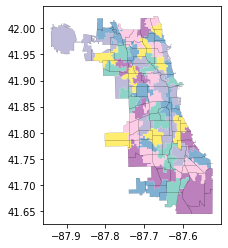

In [17]:
new_wards = geopandas.GeoDataFrame(
            {"assignment": initial.assignment.to_series()}, geometry=df.geometry).dissolve(by=assignment)
new_wards['greedy'] = greedy(new_wards)
base = new_wards.plot('greedy',categorical=True,cmap="Set3")
# draw community area boundaries on top of the new ward coloring
ca_df.plot(color="none",edgecolor="black",linewidth=.1,ax=base)

In [ ]:
# max(map(abs, gc.constraints.validity.deviation_from_ideal(initial).values()))

In [18]:
pop_target = df.TOTPOP.sum() / 50
pop_col = "TOTPOP"

In [19]:
# Configure the ReCom proposal and constraints
proposal_50 = partial(recom,
                      pop_col=pop_col,
                      pop_target=pop_target,
                      epsilon=0.05,
                      node_repeats=10)

compactness_bound = gc.constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2 * len(initial["cut_edges"]))

population_constraint = gc.constraints.within_percent_of_ideal_population(initial, 0.05)

In [20]:
steps = 1000

# Configure the Markov Chain
prec_chain50 = gc.MarkovChain(
    proposal=proposal_50,
    constraints=[compactness_bound, population_constraint],
    accept=accept.always_accept,
    initial_state=initial,
    total_steps=steps)

In [21]:
filename =f'../prec50_20pct_deviation/{datetime.now().strftime("%Y%m%d%H%M")}.json' 
keep_partitions = True
partition_list = []
with open(filename, 'w') as f:
    for i, partition in enumerate(tqdm(prec_chain50)):
        temp = json.dumps(partition.assignment.to_dict())
        f.write(temp + "\n")
        if keep_partitions:
            partition_list.append(temp)

100%|██████████| 1000/1000 [00:27<00:00, 36.97it/s]


In [35]:
# with open("../prec50_20pct_deviation/202012271025.json") as f:
#     for line in f:
#         try:
#             partitions.append(json.loads(line.strip()))

## Create results CSV

This CSV will have ward-level demographic information for each step of the chain.

In [24]:
"""
# this shit seems broke
import multiprocessing
def parallel_partitions(run, graph, updaters):
    assignments = []
    with open(filename) as f:
        for line in f:
            assignments.append(json.loads(line))
    print("loaded all assignments")
    with multiprocessing.Pool(12) as p:
        partitions = p.starmap(gc.Partition,[(graph, x, updaters) for x in  assignments])

    return [(x, partitions[x]) for x in range(len(partitions))]
"""

def partitions(run, graph, updaters):
    with open(filename) as f:
        step = 0
        for line in f:
            assignment = json.loads(line)
            partition = gc.Partition(graph, assignment, updaters=updaters)
            yield step, partition
            step += 1


In [25]:
data = pd.DataFrame.from_records(
    ([step, ward] + [partition[variable][ward] for variable in variables] + 
     [len(partition.cut_edges)] + [json.dumps(partition[variable][ward]) for variable in extra_variables] + [partition[variable] for variable in extra_metrics]
    for step, partition in tqdm(partitions("prec50", precincts, updaters), total=steps)
    for ward in partition.parts),
    columns=["step", "ward"] + variables + ["cut_edges"] + extra_variables + extra_metrics
)

100%|██████████| 1000/1000 [09:05<00:00,  1.83it/s]


In [26]:
data

,step,ward,TOTPOP,HISP,NH_WHITE,NH_BLACK,NH_ASIAN,VAP,HVAP,WVAP,...,100K_125K,125K_150K,150K_200K,200K_MORE,cut_edges,incumbency_advantage,proportions,cohesion,two_ward_cohesion,targeted_advantage_mean
0,0,0,52769.931737,10174.979653,24149.986329,3990.991644,12722.974988,39031.946496,6766.984079,18761.987791,...,1571.382336,1018.831996,1108.426693,945.135746,1278,"{""DEBRA L. SILVERSTEIN"": 0.7500000000000001}","{""contribution"": [""WEST RIDGE"", 0.628991969638...",0.343756,0.564059,0.430209
1,0,1,54925.999960,47817.999991,4259.999997,720.999999,1907.999973,35932.999972,30069.999992,3773.999998,...,566.659650,459.233555,307.182393,195.310700,1278,"{""GEORGE CARDENAS"": 0.5217391304347826, ""RAYMO...","{""contribution"": [""BRIGHTON PARK"", 0.865760823...",0.343756,0.564059,0.430209
2,0,2,52814.000324,3191.999992,2459.000005,45640.000324,889.000000,37071.000187,2122.999993,2207.000005,...,790.534599,384.936171,354.745973,214.295282,1278,"{""MICHAEL SCOTT, JR."": 0.5365853658536585, ""J...","{""contribution"": [""EAST GARFIELD PARK"", 0.9999...",0.343756,0.564059,0.430209
3,0,3,52652.000016,45735.000274,1127.000006,5457.999739,79.000000,34966.000042,30001.000175,973.000005,...,634.571825,145.225594,197.328949,58.321288,1278,"{""MICHAEL D. RODRIGUEZ"": 0.32}","{""contribution"": [""SOUTH LAWNDALE"", 0.50938836...",0.343756,0.564059,0.430209
4,0,4,53534.000097,25926.999944,9295.000024,15058.000123,2575.000003,42354.000082,17727.999978,8740.000021,...,932.886567,587.192581,654.115915,532.060109,1278,"{""BYRON SIGCHO-LOPEZ"": 0.3125}","{""contribution"": [""LOWER WEST SIDE"", 0.4077508...",0.343756,0.564059,0.430209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,999,45,56377.999689,648.999991,208.999978,54927.999719,32.000000,40418.999703,434.999991,190.999978,...,633.287049,220.477372,169.491346,142.696061,1150,"{""STEPHANIE D. COLEMAN"": 0.2222222222222222}","{""contribution"": [""WEST ENGLEWOOD"", 0.63296576...",0.350804,0.549246,0.420591
49996,999,46,54329.635194,666.996135,246.953605,52720.830581,39.999856,39863.370256,406.996356,222.954003,...,1198.775379,499.412196,480.629437,255.538582,1150,"{""ANTHONY A. BEALE"": 0.27450980392156865, ""CAR...","{""contribution"": [""WEST PULLMAN"", 0.7616219479...",0.350804,0.549246,0.420591
49997,999,47,52412.506186,23533.434210,6965.807720,21241.327613,117.953629,38333.744566,15414.516486,6236.807723,...,1285.352228,591.364617,496.381547,294.528628,1150,"{""GREGORY I. MITCHELL"": 0.4347826086956521, ""M...","{""contribution"": [""EAST SIDE"", 0.9999999999999...",0.350804,0.549246,0.420591
49998,999,48,54349.000249,2413.000014,44867.000203,3173.000004,2853.000020,48757.000224,2083.000012,41012.000187,...,3135.310495,2012.737467,2772.954479,5314.801933,1150,"{""MICHELE SMITH"": 0.869565217391304}","{""contribution"": [""LINCOLN PARK"", 0.6295442332...",0.350804,0.549246,0.420591


In [31]:
data.to_csv("../prec50_20pct_deviation/results.10000.tsv",sep='\t')

In [30]:
data[data["targeted_advantage_mean"] > .58]

,step,ward,TOTPOP,HISP,NH_WHITE,NH_BLACK,NH_ASIAN,VAP,HVAP,WVAP,...,100K_125K,125K_150K,150K_200K,200K_MORE,cut_edges,incumbency_advantage,proportions,cohesion,ca_cohesion,targeted_advantage_mean
135800,2716,0,51451.999646,12697.000026,21650.999857,4996.999914,10413.999868,40256.999730,8602.000008,18879.999876,...,1737.905924,934.653020,1291.199193,1175.572944,1227,"{""ANDR\u00c9 VASQUEZ"": 0.5641025641025641}","{""contribution"": [""WEST RIDGE"", 0.295946708719...",0.371368,0.36228,0.587493
135801,2716,1,54644.578475,16771.934370,5690.968180,31323.685276,329.998572,39323.661486,10338.957922,5110.969657,...,1537.963666,1042.420151,944.374683,262.157347,1227,"{""DERRICK G. CURTIS"": 0.7600000000000001}","{""contribution"": [""ASHBURN"", 0.865689464467028...",0.371368,0.36228,0.587493
135802,2716,2,51808.999928,8297.000001,17513.000036,11589.999935,13214.999962,44413.999930,6181.000007,16128.000033,...,2408.394233,1689.607547,1795.996561,2900.579751,1227,{},"{""contribution"": [""NEAR SOUTH SIDE"", 0.9999999...",0.371368,0.36228,0.587493
135803,2716,3,54638.617667,5665.641061,44994.983360,568.063629,2545.618983,43760.169684,3828.642622,36975.177555,...,2349.548626,1409.248850,2131.043278,1839.344049,1227,"{""ANTHONY V. NAPOLITANO"": 0.8510638297872336, ...","{""contribution"": [""EDISON PARK"", 1.0], ""contri...",0.371368,0.36228,0.587493
135804,2716,4,55245.999973,653.000000,276.000000,53503.999975,47.999999,42459.999973,422.000000,231.000000,...,932.309611,544.806713,492.407481,241.489418,1227,"{""RODERICK T. SAWYER"": 0.5}","{""contribution"": [""AVALON PARK"", 1.0], ""contri...",0.371368,0.36228,0.587493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410045,8200,45,53730.999627,11785.999917,31642.999788,6728.999952,2383.999975,46308.999683,8971.999941,29160.999806,...,2805.625609,1886.853690,2967.333175,4523.896243,1211,"{""WALTER BURNETT, JR."": 0.16}","{""contribution"": [""WEST TOWN"", 0.5782398992488...",0.337778,0.39355,0.583115
410046,8200,46,55043.999821,546.999999,222.000000,53520.999826,36.999999,42133.999877,350.000000,207.999999,...,1293.419586,527.643881,522.538503,305.305457,1211,"{""ANTHONY A. BEALE"": 0.47058823529411753}","{""contribution"": [""CHATHAM"", 0.744353214171363...",0.337778,0.39355,0.583115
410047,8200,47,52160.000197,11052.999991,16521.000005,10678.000144,13167.000050,41441.000185,7533.999993,14238.000005,...,1351.432930,743.340283,889.200428,615.376628,1211,"{""PATRICK DALEY THOMPSON"": 0.7894736842105261}","{""contribution"": [""BRIDGEPORT"", 0.826810787227...",0.337778,0.39355,0.583115
410048,8200,48,53284.952171,35709.986849,6797.998503,9278.967573,1040.000012,37453.968970,23342.993387,6043.999267,...,1162.546884,587.846289,500.146676,254.362560,1211,{},"{""contribution"": [""BELMONT CRAGIN"", 0.44358113...",0.337778,0.39355,0.583115


## Let's hunt for beneficial maps
We've got 12 alders who would CONCEIVABLY go along with this plan. We want to find a plan that:
* puts 10 of them in 10 different wards
* with maximum incumbency advantage... sum? average? median? highest minimum?
Filter to plans where 10 of them are in 10 different wards:
start with mapping (ward) -> (alders), to check an individual plan: for each ward, if at least one of gang of 12 is in ward, increment counter, if counter hits 10 this is such a map. Then, aggregate the incumbency advantage of those alders.

In [ ]:
targets = ["DANIEL LA SPATA",
"SOPHIA KING",
"LESLIE A. HAIRSTON",
"SUSAN SADLOWSKI GARZA",
"JEANETTE B TAYLOR",
"MICHAEL D. RODRIGUEZ",
"BYRON SIGCHO-LOPEZ",
"R. RODRIGUEZ SANCHEZ",
"CARLOS  RAMIREZ-ROSA",
"ANDRÉ VASQUEZ",
"MATT MARTIN",
"MARIA HADDEN"]


In [ ]:
data.groupby("step").agg(aggregate_advantages)[["ward"]].sort_values(by=["ward"],ascending=False).head(30)

<AxesSubplot:>

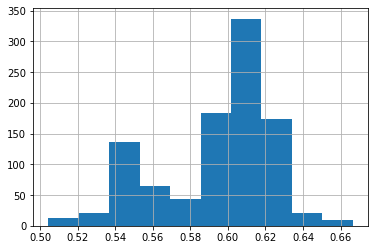

In [27]:
data.groupby("step").min()["two_ward_cohesion"].hist()

<AxesSubplot:>

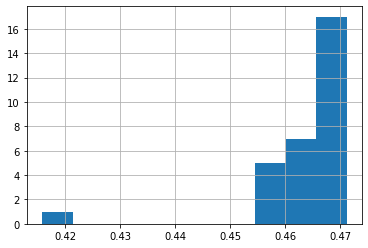

In [32]:
data[data["two_ward_cohesion"] > .64].groupby("step").min()["targeted_advantage_mean"].hist()


In [34]:
data[data["two_ward_cohesion"] > .64]

,step,ward,TOTPOP,HISP,NH_WHITE,NH_BLACK,NH_ASIAN,VAP,HVAP,WVAP,...,100K_125K,125K_150K,150K_200K,200K_MORE,cut_edges,incumbency_advantage,proportions,cohesion,two_ward_cohesion,targeted_advantage_mean
43000,860,0,52881.000126,42404.000092,5271.000032,4361.999992,347.000006,36979.000085,28631.000050,4755.000029,...,905.843700,684.027274,507.059829,398.086887,1201,{},"{""contribution"": [""HERMOSA"", 0.534604605620853...",0.358084,0.645311,0.466126
43001,860,1,54770.999796,3100.999886,39460.999934,2964.999981,7926.999997,51868.999820,2812.999902,37805.999939,...,3383.697996,2563.215420,4609.081959,7758.672561,1201,{},"{""contribution"": [""NEAR NORTH SIDE"", 0.4925170...",0.358084,0.645311,0.466126
43002,860,2,53686.999826,796.999992,1847.999978,49600.999872,609.999989,37815.999856,551.999993,1673.999979,...,654.700092,366.886012,257.414876,171.615596,1201,"{""JEANETTE B TAYLOR"": 0.7179487179487181}","{""contribution"": [""WOODLAWN"", 0.77779822028352...",0.358084,0.645311,0.466126
43003,860,3,52771.588423,20244.831243,27402.757162,745.999999,3346.000015,40656.493771,13711.736602,23109.757153,...,1690.023769,1250.430046,1313.426047,680.260764,1201,{},"{""contribution"": [""PORTAGE PARK"", 0.6444845608...",0.358084,0.645311,0.466126
43004,860,4,55220.000141,26774.000121,10310.000033,13603.999992,3731.999992,41427.000113,18311.000083,9508.000030,...,1428.919677,893.902908,844.317867,971.610584,1201,"{""BYRON SIGCHO-LOPEZ"": 0.3125, ""WALTER BURNETT...","{""contribution"": [""LOWER WEST SIDE"", 0.7156474...",0.358084,0.645311,0.466126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44495,889,45,52131.999966,44023.999967,4740.999993,547.999998,2583.000009,34605.999972,27862.999976,4190.999994,...,635.500757,475.450903,354.587099,208.506952,1191,{},"{""contribution"": [""BRIGHTON PARK"", 0.893481947...",0.358084,0.666485,0.463904
44496,889,46,54604.399709,2804.338172,34594.858912,16090.823715,314.780332,41233.680351,1716.497824,26586.702560,...,2131.983827,1610.622167,2495.213807,1993.321674,1191,"{""MATTHEW J. O'SHEA"": 0.9824561403508771}","{""contribution"": [""MOUNT GREENWOOD"", 1.0000000...",0.358084,0.666485,0.463904
44497,889,47,55829.441411,4471.439179,720.345796,49651.300992,114.066996,41809.858241,3059.870072,649.392489,...,1199.129634,503.222017,407.412610,213.061904,1191,"{""GREGORY I. MITCHELL"": 0.8260869565217388, ""M...","{""contribution"": [""SOUTH CHICAGO"", 0.802406142...",0.358084,0.666485,0.463904
44498,889,48,53914.999867,2367.999995,44382.999849,3241.000030,2864.999994,48221.999900,2028.999998,40500.999881,...,3380.858017,1978.837583,2761.653308,5391.736911,1191,"{""MICHELE SMITH"": 0.7391304347826084, ""TOM TUN...","{""contribution"": [""LINCOLN PARK"", 0.5859236640...",0.358084,0.666485,0.463904


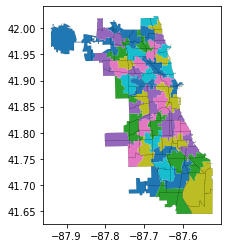

In [37]:
plot_assignment(gc.Partition(precincts,assignment=json.loads(partition_list[889])).assignment)


In [55]:
data[(data["targeted_advantage_mean"] > .5) & (data["cohesion"] > .45)]

,step,ward,TOTPOP,HISP,NH_WHITE,NH_BLACK,NH_ASIAN,VAP,HVAP,WVAP,...,100K_125K,125K_150K,150K_200K,200K_MORE,cut_edges,incumbency_advantage,proportions,cohesion,ca_cohesion,targeted_advantage_mean
26050,521,0,56015.428682,2792.339222,34146.874695,17922.835557,312.780332,42376.704947,1707.498725,26238.716244,...,2174.374118,1605.768418,2442.569602,1924.235511,1200,"{""MATTHEW J. O'SHEA"": 0.9473684210526315, ""HOW...","{""contribution"": [""MOUNT GREENWOOD"", 1.0000000...",0.458254,0.332113,0.524995
26051,521,1,53567.369649,8286.980121,36463.099301,643.364212,6701.261173,41432.893352,5599.796900,29217.398736,...,2175.976651,1331.294582,2212.938202,2178.029613,1200,"{""SAMANTHA 'SAM' NUGENT"": 0.7999999999999997, ...","{""contribution"": [""FOREST GLEN"", 1.0], ""contri...",0.458254,0.332113,0.524995
26052,521,2,52360.000015,6410.000005,26953.000012,11554.000000,6027.999998,45982.000016,5109.000004,25510.000013,...,2246.839171,1180.276634,1589.635737,1521.372317,1200,"{""JAMES CAPPLEMAN"": 0.7500000000000001}","{""contribution"": [""UPTOWN"", 0.7788431909297664...",0.458254,0.332113,0.524995
26053,521,3,52812.000181,32208.000088,17290.000090,875.000002,1824.999999,39169.000125,21648.000057,14995.000068,...,1153.580826,902.426825,882.767028,543.721130,1200,"{""ARIEL E. REBOYRAS"": 0.3125, ""FELIX CARDONA J...","{""contribution"": [""PORTAGE PARK"", 0.3968372377...",0.458254,0.332113,0.524995
26054,521,4,51456.598697,30229.767069,8841.267671,11569.569668,366.998523,35950.127888,19065.024252,7882.271058,...,1427.690957,970.503832,809.508432,261.482816,1200,"{""DERRICK G. CURTIS"": 0.2}","{""contribution"": [""ASHBURN"", 0.781442235683874...",0.458254,0.332113,0.524995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477395,9547,45,55797.000474,3374.999915,38872.000488,4281.000023,7872.000036,52934.000484,3098.999930,37272.000485,...,3532.088213,2523.387105,4720.410535,7483.927047,1182,{},"{""contribution"": [""NEAR NORTH SIDE"", 0.4578515...",0.454439,0.307330,0.502807
477396,9547,46,56327.779916,761.999467,329.994762,54559.795063,38.999857,41838.916243,474.999470,294.994762,...,1322.626778,553.273397,538.174289,296.888860,1182,"{""ANTHONY A. BEALE"": 0.3529411764705882, ""HOWA...","{""contribution"": [""ROSELAND"", 0.86044101489791...",0.454439,0.307330,0.502807
477397,9547,47,52628.000137,7720.000037,38891.000097,1433.000006,3257.999994,44301.000111,5872.000030,33471.000081,...,2785.996995,2084.842893,2113.680204,4264.875480,1182,"{""MATT MARTIN"": 0.833333333333333}","{""contribution"": [""NORTH CENTER"", 0.6473956923...",0.454439,0.307330,0.502807
477398,9547,48,55830.864706,25781.952640,19163.418310,2027.000003,7314.547791,42669.025244,17630.250956,16406.137051,...,1541.023876,919.635639,1262.271438,967.152627,1182,"{""R. RODRIGUEZ SANCHEZ"": 0.5714285714285713}","{""contribution"": [""ALBANY PARK"", 0.51669271662...",0.454439,0.307330,0.502807


In [60]:
data[data["step"] == 521][(data["HISP"] / data["TOTPOP"] > .5)]

,step,ward,TOTPOP,HISP,NH_WHITE,NH_BLACK,NH_ASIAN,VAP,HVAP,WVAP,...,100K_125K,125K_150K,150K_200K,200K_MORE,cut_edges,incumbency_advantage,proportions,cohesion,ca_cohesion,targeted_advantage_mean
26053,521,3,52812.000181,32208.000088,17290.000090,875.000002,1824.999999,39169.000125,21648.000057,14995.000068,...,1153.580826,902.426825,882.767028,543.721130,1200,"{""ARIEL E. REBOYRAS"": 0.3125, ""FELIX CARDONA J...","{""contribution"": [""PORTAGE PARK"", 0.3968372377...",0.458254,0.332113,0.524995
26054,521,4,51456.598697,30229.767069,8841.267671,11569.569668,366.998523,35950.127888,19065.024252,7882.271058,...,1427.690957,970.503832,809.508432,261.482816,1200,"{""DERRICK G. CURTIS"": 0.2}","{""contribution"": [""ASHBURN"", 0.781442235683874...",0.458254,0.332113,0.524995
26057,521,7,52630.000270,27364.000076,3923.000068,18562.000009,2284.000116,35166.000212,17098.000053,3365.000062,...,647.028296,196.221932,226.322931,154.582066,1200,{},"{""contribution"": [""NEW CITY"", 0.64036187680918...",0.458254,0.332113,0.524995
26060,521,10,54568.000047,39849.000110,2475.000017,11520.999916,244.000000,37468.000031,26722.000070,2232.000015,...,836.931299,485.538095,338.570501,280.896862,1200,{},"{""contribution"": [""HUMBOLDT PARK"", 0.671982571...",0.458254,0.332113,0.524995
26062,521,12,51658.281253,29055.415696,9203.754462,12791.178027,122.953209,35579.583860,19157.503232,8207.755304,...,1261.773817,360.910730,437.889293,248.335380,1200,"{""SUSAN SADLOWSKI GARZA"": 0.8888888888888892}","{""contribution"": [""HEGEWISCH"", 1.0], ""contribu...",0.458254,0.332113,0.524995
26063,521,13,53843.999601,44427.999622,4629.999987,1425.000020,3090.999970,36435.999744,28803.999770,4079.999987,...,762.248433,416.896162,364.286305,140.761064,1200,"{""EDWARD M. BURKE"": 0.25806451612903225}","{""contribution"": [""MCKINLEY PARK"", 1.0], ""cont...",0.458254,0.332113,0.524995
26068,521,18,55331.119237,29100.761951,14646.916676,2516.535726,7517.904886,41534.047768,19758.761944,12638.916680,...,1393.387048,884.662762,987.145971,587.863850,1200,"{""R. RODRIGUEZ SANCHEZ"": 0.5714285714285713}","{""contribution"": [""ALBANY PARK"", 0.71174998099...",0.458254,0.332113,0.524995
26076,521,26,53844.005742,38473.357015,3817.676756,10996.000218,293.971752,37089.743960,25420.076707,3398.681471,...,898.946717,383.938653,268.033878,95.710376,1200,"{""MICHAEL D. RODRIGUEZ"": 0.7999999999999999}","{""contribution"": [""ARCHER HEIGHTS"", 0.50099712...",0.458254,0.332113,0.524995
26085,521,35,55871.000047,31527.000008,9022.999990,11621.000033,3123.000010,44199.000032,21798.000010,8531.999991,...,949.742433,507.693553,628.102574,398.500362,1200,"{""BYRON SIGCHO-LOPEZ"": 0.5}","{""contribution"": [""LOWER WEST SIDE"", 0.9207729...",0.458254,0.332113,0.524995
26086,521,36,51341.000013,44242.000013,3602.000004,2268.999991,1028.000005,33458.000011,27726.000012,3195.000004,...,552.256486,382.953216,245.622662,182.965833,1200,"{""GEORGE CARDENAS"": 0.08695652173913043, ""RAYM...","{""contribution"": [""BRIGHTON PARK"", 0.644882365...",0.458254,0.332113,0.524995
